# Dynamics and Model Discovery

##### Diego Alba, AMATH 563, 5/2020

### Abstract:

The goal of this assignment is to evaluate differnt data-driven model discovery techniques, as well as to implement statistics to compare and rank modelpredictions. Two different dataset will be used, time series of population dynamics and snapshots of chemical reactions.

### Background

The first dataset, concerning Canadian lynx and snowshoe hare populations from 1845 to 1903, contains 30 pairs of datapoints. We will see that in order to use some of the methods we will have to interpolate between the data to generate more points. The second dataset contains 1200 images of the Belousov-Zhabotinsky chemical oscillator.

The main model discovery techniqiue in this assignment will be Dynamic Mode Decomposition (DMD). The idea here is to find the best linear approximation to the dynamical system by projecting into a low rank space that captures the most important feattues (dynamic modes) of the system. This allows for good near-future predictions, and beacuse of cheap computations, it can be performed real time.

In order to apply DMD to cases with a small amout of data, or where not all variables are know, one can do time delay embeddings. That is, to make new variables from the ones available by shifting them in time. Similarly, another embedding technique is to apply a library of functions, such as polynomials, to the original data. Both techniques are able to find more accurate dynamical modes. Moreover, these versions of DMD can be coupled with regularization schemas such as L1 in order to promote sparsity and make the dynamic modes more interpretable.

To compare results we use several statistics. Kullback–Leibler divergence (KL divergence) is related to the Shanon entropy as measure of information or suprise and compares the similarity between a probablity distribution and a reference probability distribution. Akaike information criterion (AIC) is a measure that tries to compare models by not only contrasting the errors but also the number of parameters. Lastly, Bayesian information criterion (BIC) is similar to AIC, but with a different penalty for the number of parameters That is, with AIC the penalty is 2k, whereas with BIC the penalty is ln(n)k.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import HTML
print("HTML Settings, don't know how to remove these two blocks")
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: center;
}
</style>
""")

HTML Settings, don't know how to remove these two blocks


In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import h5py
import numpy as np
from scipy.interpolate import interp1d
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.stats import entropy

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

### Implementation and Results

The fist thing we'll set up some settings for the Jupyter notebook and import all of the packages required to carry out the analysis and plotting.

We load the data and interpolate. This is depicted in Figure 1.

In [5]:
hare = np.array([20,20,52,83,64,68,83,12,36,150,110,60,7,10,70,100,92,70,10,11,137,137,18,22,52,83,18,10,9,65])
lynx = np.array([32,50,12,10,13,36,15,12,6,6,65,70,40,9,20,34,45,40,15,15,60,80,26,18,37,50,35,12,12,25])
year = np.arange(1845,1905,2)

h = interp1d(year,hare, kind = 'quadratic')
l = interp1d(year,lynx, kind = 'quadratic')
y = np.arange(1845,1903,0.25)
hnew = h(y)
lnew = l(y)

                               Figure 1


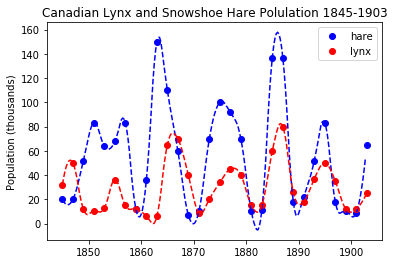

In [6]:
plt.plot(year, hare,'bo', label = 'hare')
plt.plot(year, lynx,'ro', label = 'lynx')

plt.plot(y, hnew,'b--')
plt.plot(y, lnew,'r--')

plt.legend()
plt.title('Canadian Lynx and Snowshoe Hare Polulation 1845-1903')
plt.ylabel('Population (thousands)');
print('                               Figure 1')

We go ahead and split the data into a train and test set. Because this is a time series and we would be interested in making predictions at future time points, we select the last 20% to be the test set (the split is denoted with a vertical line in the next figures).

We use classis DMD to try to find the dynamic modes of the system. We are very limited as there's only data for two varibles and that is the dimensionality of our low rank space. In Figure 2, we can see how the model does oscillate but not with the right frequency or amplitude (it even goes negative). The predictions are also very poor.

In [7]:
def DMD(X,Xprime,r):
    
    # Step 1
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) 
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    # Step 2
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T 
    
    # Step 3
    Lambda, W = np.linalg.eig(Atilde) 
    Lambda = np.diag(Lambda)
    
    # Step 4
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W 
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [8]:
t = np.arange(0,np.diff(y)[0]*len(y), np.diff(y)[0])
hnew_train, hnew_test, lnew_train, lnew_test, y_train, y_test, t_train, t_test= train_test_split(hnew, lnew, y, t, test_size= 0.2, shuffle = False)

In [9]:
x = np.array([hnew_train,lnew_train])
x1 = x[:,:-1]
x2 = x[:,1:]

Phi, Lambda, b = DMD(x1,x2,2)
om = np.log(np.diag(Lambda))/np.diff(y)[0]

dmd_train = np.real(Phi@(b[np.newaxis].T*np.exp(om[np.newaxis].T*t_train)))
dmd_test = np.real(Phi@(b[np.newaxis].T*np.exp(om[np.newaxis].T*t_test)))

                               Figure 2


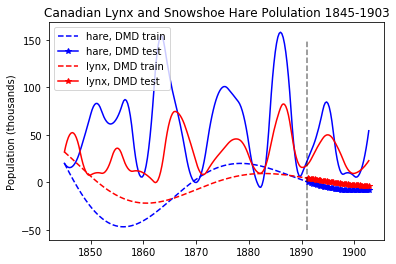

In [10]:
plt.plot(y, hnew, 'b')
plt.plot(y_train, dmd_train[0,:],'b--', label = 'hare, DMD train')
plt.plot(y_test, dmd_test[0,:],'b*-', label = 'hare, DMD test')
plt.plot(y, lnew, 'r')
plt.plot(y_train, dmd_train[1,:],'r--', label = 'lynx, DMD train')
plt.plot(y_test, dmd_test[1,:],'r*-', label = 'lynx, DMD test')
plt.plot([y_train[-1],y_train[-1]],[-50,150],'k--', alpha = 0.5)
plt.legend()
plt.title('Canadian Lynx and Snowshoe Hare Polulation 1845-1903')
plt.ylabel('Population (thousands)')
print('                               Figure 2')

We try to imrpove these results by time-delay embedding. We make a total of 82 embeddings and do DMD on this data. In Figure 3 we can see the results are much better, both in terms of fitting to the training set and predicting the test set. We can see one the effects of using a low rank and linear approximation as the prediction gets worse over time.

In [11]:
E = int(np.round(len(y_train)/2.25))
L = len(y_train)-E
H = np.zeros((len(x)*E,L))

for i,j in zip(range(E),range(0,len(H),len(x))):
    H[j] = x[0,i:i+L]
    H[j+1] = x[1,i:i+L]

In [12]:
X = H
x1 = X[:,:-1]
x2 = X[:,1:]

Phi, Lambda, b = DMD(x1,x2,15)
om = np.log(np.diag(Lambda))/np.diff(y)[0]

ddmd_train = np.real(Phi@(b[np.newaxis].T*np.exp(om[np.newaxis].T*t_train)))
ddmd_test = np.real(Phi@(b[np.newaxis].T*np.exp(om[np.newaxis].T*t_test)))

                               Figure 3


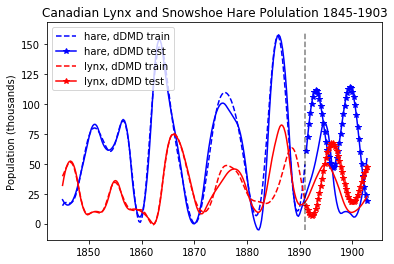

In [13]:
plt.plot(y, hnew, 'b')
plt.plot(y_train, ddmd_train[0,:],'b--', label = 'hare, dDMD train')
plt.plot(y_test, ddmd_test[0,:],'b*-', label = 'hare, dDMD test')
plt.plot(y, lnew, 'r')
plt.plot(y_train, ddmd_train[1,:],'r--', label = 'lynx, dDMD train')
plt.plot(y_test, ddmd_test[1,:],'r*-', label = 'lynx, dDMD test')
plt.plot([y_train[-1],y_train[-1]],[-5,160],'k--', alpha = 0.5)
plt.legend()
plt.title('Canadian Lynx and Snowshoe Hare Polulation 1845-1903')
plt.ylabel('Population (thousands)')
print('                               Figure 3')

We also try to fit the data to the well-known Lotka-Volterra model, which uses 4 parameters that describe the interactions between species. We do this by defining the system of ODEs, integrating with scipy.odeint, calculating the square error between the data and model, and using scipy.minimize to drive the error down by changing the parameters. The best minimazation algorithm used was Nelder-Mead, but we can see in Figure 4 that this solution is worse that time-delayed DMD.

In [14]:
xLV = np.array([hare, lynx])
def run(t, b, p, r, d):
    
    def LVode(x,t):
        new_x = np.zeros(x.shape)
        new_x[0] = (b-p*x[1])*x[0]
        new_x[1] = (r*x[0]-d)*x[1]    
        return new_x
    
    return odeint(LVode, x[:,0], t).flatten()

def residual(params,t,data):
    sol = run(t,*params)
    error = np.sum(((data-sol)**2)/data)
    return error

In [15]:
xz = [0.25,0.005,0.0136,0.3]

k_fit = minimize(residual,xz, args = (np.arange(0,np.diff(year)[0]*len(year), np.diff(year)[0]), xLV.T.flatten()), method ='Nelder-Mead', options = {'maxiter':10000})

                               Figure 4


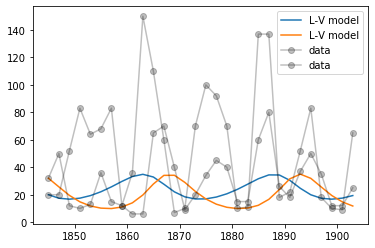

In [16]:
xhat = run(year, *k_fit.x)
plt.plot(np.array([year,year]).T, np.reshape(xhat, (len(year),2)),label = 'L-V model')
plt.plot(np.array([year,year]).T, np.reshape(xLV.T.flatten(), (len(year),2)),'ko-', alpha = 0.25, label = 'data')
plt.legend()
print('                               Figure 4')

Lastly, we try to use sparse regression to fit a nonlinear, dynamical systems model to the data (SINDy). We do this by creating a library of functions (x,y,x*y,x^2,y^2, (x*y)^2) and applying them to the population data. We can see this gives better results than fitting the Lotka-Volterra model, but worse than time-delay DMD.

In [17]:
def build_X(h,l):
    return np.array([h,l,h*l,h**2, l**2, (h*l)**2]).T

h = hnew_train
l = lnew_train
Xdot_train = np.diff(np.array([h,l])).T
Xdot_test = np.diff(np.array([hnew_test,lnew_test])).T

h = h[:-1]; l = l[:-1]
Xtrain = build_X(h,l)
Xtest = build_X(hnew_test[:-1], lnew_test[:-1])

In [18]:
lasso = Lasso()
lasso.fit(Xtrain,Xdot_train)
true = np.copy(lasso.coef_)

Xdot_train_hat = lasso.predict(Xtrain)
Xdot_test_hat = lasso.predict(Xtest)

X_train = np.r_[np.array([h[0],l[0]],ndmin=2), Xdot_train].cumsum(axis=0)
X_train_hat = np.r_[np.array([h[0],l[0]],ndmin=2), Xdot_train_hat].cumsum(axis=0)
X_test = np.r_[np.array([hnew_test[0],lnew_test[0]],ndmin=2), Xdot_test].cumsum(axis=0)
X_test_hat = np.r_[np.array([hnew_test[0],lnew_test[0]],ndmin=2), Xdot_test_hat].cumsum(axis=0)

                               Figure 5


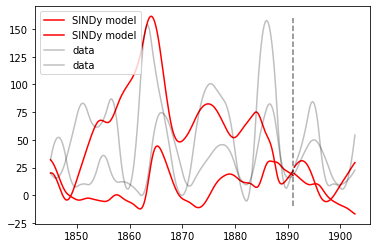

In [19]:
plt.plot(np.array([y_train ,y_train]).T, X_train_hat,'r',label = 'SINDy model')
plt.plot(np.array([y_train ,y_train]).T, X_train,'k', alpha = 0.25 ,label = 'data')

plt.plot(np.array([y_test ,y_test]).T, X_test_hat,'r')
plt.plot(np.array([y_test ,y_test]).T, X_test,'k', alpha = 0.25)
plt.plot([y_train[-1],y_train[-1]],[-10,160],'k--', alpha = 0.5)

plt.legend()
print('                               Figure 5')

To compare across models, we calculate the population distribution accross all years for the data and each of the models, and calculate the KL divergence, AIC, and BIC scores. In Figure 6 we can clearly see that time-delay DMD gives the best results.

In [20]:
nbins = 15
x_pdf, bins = np.histogram(x, bins = nbins, density = True)

dmd_pdf, bins = np.histogram(np.r_[dmd_train.T], bins = nbins, density = True)
ddmd_pdf, bins = np.histogram(np.r_[ddmd_train[0:2,:].T], bins = nbins, density = True)
xLV_pdf, bins = np.histogram(xLV, bins = nbins, density = True)
xtrain_pdf, bins = np.histogram(X_train_hat, bins = nbins, density = True)


Figure 6


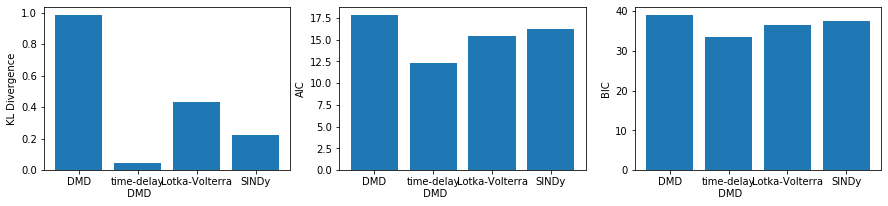

In [21]:
KLs = []
KLs.append(entropy(dmd_pdf, x_pdf))
KLs.append(entropy(ddmd_pdf, x_pdf))
KLs.append(entropy(xLV_pdf, x_pdf))
KLs.append(entropy(xtrain_pdf, x_pdf))

plt.figure(figsize = (15,3))
plt.subplot(131)
plt.bar(range(4),KLs)
plt.xticks(range(4),['DMD','time-delay\n DMD','Lotka-Volterra','SINDy'])
plt.ylabel('KL Divergence');

AIC = []
k = 4

AIC.append(np.sum(np.abs(dmd_train-x))/len(x.flatten())*len(x.flatten()))
AIC.append(np.sum(ddmd_train[0:2,:]-x)/len(x.flatten())*len(x.flatten()))
AIC.append(np.sum(np.abs(np.reshape(xhat, (len(year),2))-xLV.T))/len(xLV.flatten())*len(xLV.flatten()))
AIC.append(np.sum(X_train-X_train_hat)/len(X_train.flatten())*len(X_train.flatten()))

BIC = np.log(AIC) +k*np.log(len(x.flatten())*4)
AIC = np.log(AIC) +2*k

plt.subplot(132)
plt.bar(range(4),AIC)
plt.xticks(range(4),['DMD','time-delay\n DMD','Lotka-Volterra','SINDy'])
plt.ylabel('AIC')

plt.subplot(133)
plt.bar(range(4),BIC)
plt.xticks(range(4),['DMD','time-delay\n DMD','Lotka-Volterra','SINDy'])
plt.ylabel('BIC')

print('Figure 6')

Switching gears to the Belousov-Zhabotinsky chemical oscillator dataset. We load the data and display 10 images at different time points in Figure 7.

In [22]:
with h5py.File('BZ.mat', 'r') as f:
    data = f.get('BZ_tensor')[()]

Figure 7


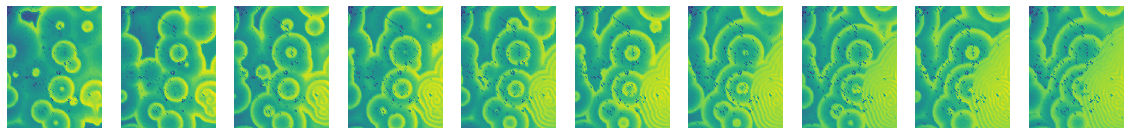

In [23]:
plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(data[int(i*len(data)/10)])
    plt.axis('off');
print('Figure 7')

Next, because the size of the images is too big, we reduce them to 50x39 and split it again into 80% train test and 20% test set. Moreover, we vectorize the images so at the end every row is a pixel and evry colum its evolution in time. We do DMD on the vecotrized images, and we also try time-delay embedding of 10. All the results and comparisson with the risized images is presented in Figure 8.

In [24]:
small = resize(data, (1200,50,39), anti_aliasing=True)
train, test = train_test_split(small, shuffle = False, test_size = 0.2)

Xreal = np.swapaxes(np.reshape(small,(len(small),int(np.prod(small.shape)/len(small)))),0,1)

X = np.swapaxes(np.reshape(train,(len(train),int(np.prod(train.shape)/len(train)))),0,1)
X1 = X[:,:-1]
X2 = X[:,1:]

Phi, Lambda, b = DMD(X1,X2,15)
om = np.log(np.diag(Lambda))

u_dmd_train = Phi@(b[np.newaxis].T*np.exp(om[np.newaxis].T*np.arange(0, len(data))))


In [25]:
E = 10
L = (X.shape[1])-E
H = np.zeros((X.shape[0]*E,L))

for i,j in zip(range(E),range(0,len(H),X.shape[0])):
    H[j:j+X.shape[0]] = X[:,i:i+L]


In [26]:
X = H
x1 = X[:,:-1]
x2 = X[:,1:]

Phi, Lambda, b = DMD(x1,x2,15)
om = np.log(np.diag(Lambda))

u_ddmd_train = Phi@(b[np.newaxis].T*np.exp(om[np.newaxis].T*np.arange(0, len(data))))

In [27]:
XX = np.reshape(np.swapaxes(np.real(Xreal),0,1),small.shape)
Xtrain = np.reshape(np.swapaxes(np.real(u_dmd_train),0,1),small.shape)
dXtrain = np.reshape(np.swapaxes(np.real(u_ddmd_train[:1950,:]),0,1),small.shape)

datapr = np.zeros(small.shape)
datatrain = np.zeros(small.shape)
ddatatrain = np.zeros(small.shape)

for n,i in enumerate(XX):
    datapr[n,::] = resize(XX[n,::], datapr.shape[1:], anti_aliasing=True)
    datatrain[n,::] = resize(Xtrain[n,::], datatrain.shape[1:], anti_aliasing=True)
    ddatatrain[n,::] = resize(dXtrain[n,::], ddatatrain.shape[1:], anti_aliasing=True)



Figure 8


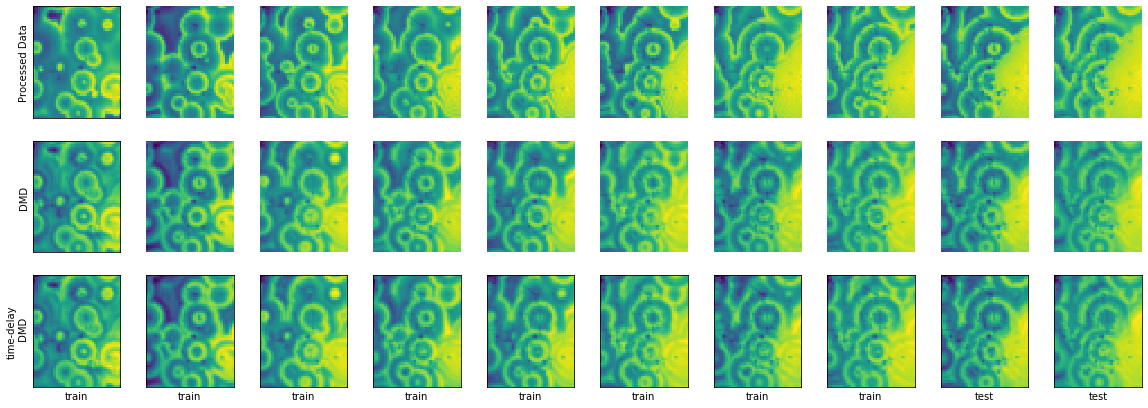

In [28]:
plt.figure(figsize=(20,7))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(datapr[int(i*len(data)/10)])
    if i == 0: plt.ylabel('Processed Data'); plt.xticks([]); plt.yticks([])
    else: plt.axis('off');

    plt.subplot(3,10,10+i+1)
    plt.imshow(datatrain[int(i*len(train)/10)])
    if i == 0: plt.ylabel('DMD'); plt.xticks([]); plt.yticks([])
    else: plt.axis('off');
        
    plt.subplot(3,10,20+i+1)
    plt.imshow(ddatatrain[int(i*len(train)/10)])
    if i == 0: plt.ylabel('time-delay\n DMD'); 
    else: plt.ylabel('');
    plt.xticks([]); plt.yticks([])

    if i <= 7: plt.xlabel('train')
    else: plt.xlabel('test')

print('Figure 8')

We can observe that in this case both DMD and time-delay DMD are very good, both when fitting to the training set and predicting the test set. This is porbably because the amount of data is much larger than in the Canadian lynx and snowshoe hare populations dynamics dataset.

### Conlcusion

We have shown how to use different DMD variations for data-driven system identification for two very different datasets. Particularly, we have seen that the algorithm time-delay embedding is incredibly very useful when theres limited amounts of data or only a few variables have been measured. Moreover, we have shown how to compare moedls with different statistical score, such as KL divergence.

### Appendix

The full Jupyter Notebook containing the report and the code used can be found at https://github.com/DIEGOA363/ISCS